In [205]:
import pandas as pd
import windaq as wdq
import matplotlib.pyplot as plt
from pathlib import Path

In [206]:
import os
from tkinter import Tk, filedialog

def select_folder_and_find_files(extension=".WDH"):
    # Hide the Tkinter root window
    root = Tk()
    root.withdraw()
    
    # Prompt the user to select a folder
    folder_path = filedialog.askdirectory(title="Select a Folder")
    if not folder_path:
        print("No folder selected.")
        return []
    
    # Find and return all files with the given extension
    matching_files = []
    for root_dir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(extension):
                matching_files.append(os.path.join(root_dir, file))
    
    return matching_files

def find_files(folder_path, extension=".WDH"):  
    # Find and return all files with the given extension
    matching_files = []
    for root_dir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(extension):
                matching_files.append(os.path.join(root_dir, file))
    
    return matching_files

In [207]:
def wdh_to_df(file):
    wfile = wdq.windaq(file)
    tdata = wfile.time()
    data = {}
    for ch in range(wfile.nChannels):
        data['ch'] = wfile.data(ch)

    df = pd.DataFrame({ 'time, s':       wfile.time(),
                        'speed, rpm':    wfile.data(3),
                        'torque, Nm':    wfile.data(1),
                        'temp, degF':    wfile.data(2)})
    
    # df['torque, Nm'] = df['torque, Nm'] * -1
    return df

In [ ]:
def plot_torque_stand_data(df, test_name, start_time=0, stop_time=0):
    # Filter the dataframe to only include the specified time chunk
    if stop_time != 0:
        df_plot = df[(df['time, s'] >= start_time) & (df['time, s'] <= stop_time)]
    else:
        df_plot = df

    # Create a figure with three vertically stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

    # Plot the speed data on the first subplot
    ax1.plot(df_plot['time, s'], df_plot['speed, rpm'], label='Speed', color="red")
    ax1.set_ylabel("Speed, rpm", color="red")
    ax1.set_title(f"{test_name} Data - Speed, Torque, and Temperature over Time")
    ax1.grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)

    # Plot the torque data on the second subplot
    ax2.plot(df_plot['time, s'], df_plot['torque, Nm'], label='Torque', color="blue")
    ax2.set_ylabel("Torque, Nm", color="blue")
    ax2.grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)

    # Plot the temperature data on the third subplot
    ax2 = plt.twinx(ax2)
    ax2.plot(df_plot['time, s'], df_plot['temp, degF'], label='Temperature', color="green")
    ax2.set_ylabel("Temperature, degF", color="green")    

    # Adjust layout to prevent overlap
    plt.tight_layout()

    return plt

import matplotlib.ticker as ticker

def plot_filter_torque_stand_data(df, test_name, start_time=0, stop_time=0):
    # Filter the dataframe to only include the specified time chunk
    if stop_time != 0:
        df_plot = df[(df['time, s'] >= start_time) & (df['time, s'] <= stop_time)]
    else:
        df_plot = df

    # Create a figure with two vertically stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

    # Plot the speed data on the first subplot
    ax1.plot(df_plot['time, s'], df_plot['speed, rpm'], label='Speed', color="red")
    ax1.set_ylabel("Speed, rpm", color="red")
    ax1.set_title(f"{test_name} Data - Speed, Torque, and Temperature over Time")
    ax1.grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)
    ax1.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.5)  # Add minor gridlines
    ax1.legend(loc="upper left")  # Add legend to the first subplot

    # Add minor tick locators
    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))  # 5 minor ticks between major ticks
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))  # 5 minor ticks between major ticks

    # Plot the torque data on the second subplot
    ax2.plot(df_plot['time, s'], df_plot['torque, Nm'], label='Original Torque', color="red")
    ax2.plot(df_plot['time, s'], df_plot['torque, Nm (filtered)'], label='Filtered Torque', color="blue")
    ax2.set_ylabel("Torque, Nm", color="red")
    ax2.set_xlabel("Time, sec")
    ax2.grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)
    ax2.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.5)  # Add minor gridlines
    ax2.legend(loc="upper left")  # Add legend for the second subplot

    # Add minor tick locators
    ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))  # 5 minor ticks between major ticks
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))  # 5 minor ticks between major ticks

    # Add temperature data to the second subplot with a secondary y-axis
    ax_temp = ax2.twinx()
    ax_temp.plot(df_plot['time, s'], df_plot['temp, degF'], label='Temperature', color="green", alpha=0.3)
    ax_temp.set_ylabel("Temperature, degF", color="green")
    ax_temp.set_ylim(70, 200)
    ax_temp.legend(loc="upper right")  # Add legend for the temperature plot

    # Adjust layout to prevent overlap
    plt.tight_layout()

    return plt


In [209]:
import os

folder = Path("C:\\Users\\Stephen.Garden\\Trelleborg AB\\Private TTC Site - General\\TTC Projects\\Active Projects\\P21995 21996 21997 Torque Testing\\shakedown runs\\data for processing")
file_paths = select_folder_and_find_files()
data_files = {}
for path in file_paths:
    # Extract the filename without the extension
    filename = os.path.splitext(os.path.basename(path))[0]
    # Use the filename as the key in the dictionary
    data_files[filename] = wdh_to_df(path)

In [210]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_fft(df, column, sampling_rate, sort_by_magnitude=False,
                start_time=None, stop_time=None, ):
    """
    Perform FFT on a specified column of the dataframe, optionally for a specific time range.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        column (str): The column to analyze.
        sampling_rate (float): The sampling rate in Hz.
        start_time (float): Start time in seconds (default is None for the beginning of the data).
        stop_time (float): Stop time in seconds (default is None for the end of the data).
        sort_by_magnitude (bool): Whether to sort the output by magnitude (default is False).

    Returns:
        freqs (np.array): Array of frequency values.
        magnitude (np.array): FFT magnitude spectrum.
    """
    # Filter data based on start and stop time
    if start_time is not None or stop_time is not None:
        df = df[
            (df['time, s'] >= (start_time if start_time is not None else df['time, s'].min())) &
            (df['time, s'] <= (stop_time if stop_time is not None else df['time, s'].max()))
        ]

    # Perform FFT
    data = df[column] - df[column].mean()  # Remove DC offset
    fft_result = np.fft.fft(data)
    fft_magnitude = np.abs(fft_result)[:len(data)//2]  # Only take positive frequencies
    fft_freqs = np.fft.fftfreq(len(data), d=1/sampling_rate)[:len(data)//2]

    if sort_by_magnitude:
        # Sort by magnitude in descending order
        sorted_indices = np.argsort(fft_magnitude)[::-1]
        fft_freqs = fft_freqs[sorted_indices]
        fft_magnitude = fft_magnitude[sorted_indices]

    return fft_freqs, fft_magnitude



def plot_torque_speed_fft(df, sampling_rate, start_time=None, stop_time=None,
                          start_freq=0, stop_freq=0):
    # Filter data based on the time range
    # Filter data based on start and stop time
    if start_time is not None or stop_time is not None:
        df = df[
            (df['time, s'] >= (start_time if start_time is not None else df['time, s'].min())) &
            (df['time, s'] <= (stop_time if stop_time is not None else df['time, s'].max()))
        ]
    
    # Perform FFT analysis for torque and speed
    torque_freqs, torque_magnitude = analyze_fft(df, 'torque, Nm', sampling_rate)
    speed_freqs, speed_magnitude = analyze_fft(df, 'speed, rpm', sampling_rate)
    
    # Filter frequencies based on start_freq and stop_freq
    if stop_freq == 0:  # Default to Nyquist frequency
        stop_freq = sampling_rate / 2
    
    torque_mask = (torque_freqs >= start_freq) & (torque_freqs <= stop_freq)
    speed_mask = (speed_freqs >= start_freq) & (speed_freqs <= stop_freq)

    # Plot the FFT results
    plt.figure(figsize=(16, 6))
    
    # Torque FFT
    plt.subplot(2, 1, 1)
    plt.plot(torque_freqs[torque_mask], torque_magnitude[torque_mask], label="Torque FFT", color="blue")
    plt.title("FFT Analysis of Torque and Speed")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    #plt.ylim(0,500)
    plt.grid(True)
    plt.legend()
    
    # Speed FFT
    plt.subplot(2, 1, 2)
    plt.plot(speed_freqs[speed_mask], speed_magnitude[speed_mask], label="Speed FFT", color="red")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    #plt.ylim(0,100000)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

from scipy.signal import iirnotch, filtfilt, butter

def notch_filter(data, sampling_rate, notch_freq, quality_factor):
    """
    Apply a notch filter to suppress a specific frequency.

    Parameters:
        data (np.array): The time-series data to filter.
        sampling_rate (float): The sampling rate in Hz.
        notch_freq (float): The frequency to suppress.
        quality_factor (float): The quality factor, controlling bandwidth (higher = narrower).

    Returns:
        np.array: The filtered data.
    """
    nyquist = 0.5 * sampling_rate
    w0 = notch_freq / nyquist  # Normalized frequency
    b, a = iirnotch(w0, Q=quality_factor)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


def bandstop_filter(data, sampling_rate, lowcut, highcut):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='bandstop')
    return filtfilt(b, a, data)

def lowpass_filter(data, sampling_rate, cutoff_freq, order=4):
    """
    Apply a low-pass filter to the data.

    Parameters:
        data (np.array or pd.Series): The input signal.
        sampling_rate (float): The sampling rate in Hz.
        cutoff_freq (float): The cutoff frequency in Hz.
        order (int): The order of the filter (default is 4).

    Returns:
        np.array: The filtered signal.
    """
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


21996_greased_S1_12052024


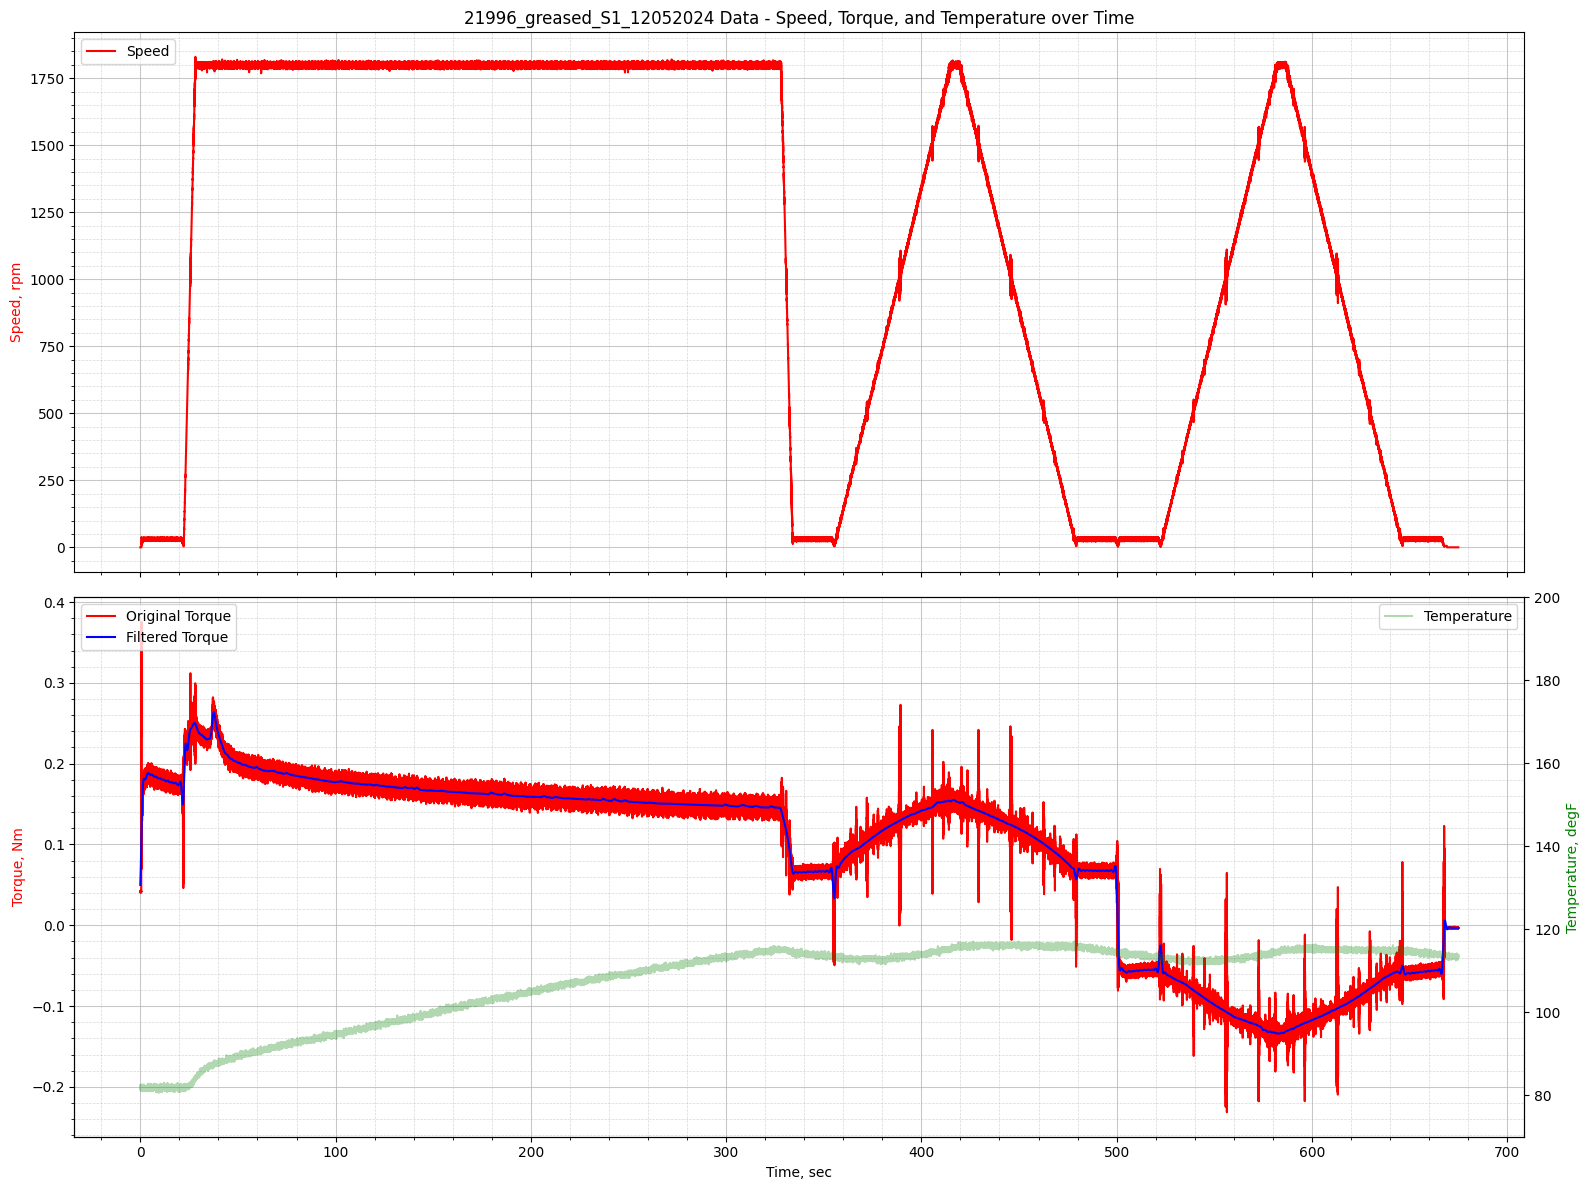

Frequency: 17.98 Hz, Magnitude: 13.92
Frequency: 17.99 Hz, Magnitude: 13.77
Frequency: 17.98 Hz, Magnitude: 12.90
Frequency: 18.00 Hz, Magnitude: 10.56
Frequency: 0.50 Hz, Magnitude: 10.40
Frequency: 0.54 Hz, Magnitude: 9.50
Frequency: 0.51 Hz, Magnitude: 9.48
Frequency: 0.52 Hz, Magnitude: 9.37
Frequency: 0.66 Hz, Magnitude: 9.14
Frequency: 17.97 Hz, Magnitude: 8.86
Frequency: 0.54 Hz, Magnitude: 8.77
Frequency: 0.52 Hz, Magnitude: 8.69
Frequency: 18.02 Hz, Magnitude: 8.59
Frequency: 0.55 Hz, Magnitude: 8.58
Frequency: 18.02 Hz, Magnitude: 8.30
Frequency: 18.03 Hz, Magnitude: 8.21
Frequency: 17.99 Hz, Magnitude: 8.11
Frequency: 17.99 Hz, Magnitude: 8.06
Frequency: 0.51 Hz, Magnitude: 8.05
Frequency: 18.00 Hz, Magnitude: 7.82
Frequency: 0.69 Hz, Magnitude: 7.75
Frequency: 0.66 Hz, Magnitude: 7.74
Frequency: 0.53 Hz, Magnitude: 7.65
Frequency: 0.75 Hz, Magnitude: 7.64
Frequency: 0.68 Hz, Magnitude: 7.55
Frequency: 0.67 Hz, Magnitude: 7.44
Frequency: 0.76 Hz, Magnitude: 7.27
Frequency: 1

In [ ]:
lowpass_cutoff = 0.5

for test in data_files:
    print(test)
    plt = plot_filter_torque_stand_data(data_files[test], test, start_time=0, stop_time=675) #325 start_time for sweeps
    plt.show()

data_files[test]['torque, Nm (filtered)'] = lowpass_filter(
    data=data_files[test]['torque, Nm'],
    sampling_rate=100,
    cutoff_freq=lowpass_cutoff,
    order=4
)

# Analyze FFT
freqs, magnitudes = analyze_fft(
    data_files[test], 
    column="torque, Nm", 
    sampling_rate=100, 
    sort_by_magnitude=True,
    start_time=350
)

In [ ]:
### ANALYZE STRONGEST FREQUENCIES OF TORQUE DATA

## Set thresholds
min_threshold = 0.5  # Minimum frequency
max_threshold = 20  # Maximum frequency

# Create a mask for frequencies within the specified range
filtered_indices = (freqs >= min_threshold) & (freqs <= max_threshold)

# Apply the filter to both frequencies and magnitudes
filtered_freqs = freqs[filtered_indices]
filtered_magnitudes = magnitudes[filtered_indices]

# Sort the filtered results by magnitude in descending order
sorted_indices = np.argsort(filtered_magnitudes)[::-1]
sorted_freqs = filtered_freqs[sorted_indices]
sorted_magnitudes = filtered_magnitudes[sorted_indices]

# Print the top results within the frequency range
for i in range(min(50, len(sorted_freqs))):  # Ensure we don't exceed available data
    print(f"Frequency: {sorted_freqs[i]:.2f} Hz, Magnitude: {sorted_magnitudes[i]:.2f}")

Frequency: 17.98 Hz, Magnitude: 13.92
Frequency: 17.99 Hz, Magnitude: 13.77
Frequency: 17.98 Hz, Magnitude: 12.90
Frequency: 18.00 Hz, Magnitude: 10.56
Frequency: 0.50 Hz, Magnitude: 10.40
Frequency: 0.54 Hz, Magnitude: 9.50
Frequency: 0.51 Hz, Magnitude: 9.48
Frequency: 0.52 Hz, Magnitude: 9.37
Frequency: 0.66 Hz, Magnitude: 9.14
Frequency: 17.97 Hz, Magnitude: 8.86
Frequency: 0.54 Hz, Magnitude: 8.77
Frequency: 0.52 Hz, Magnitude: 8.69
Frequency: 18.02 Hz, Magnitude: 8.59
Frequency: 0.55 Hz, Magnitude: 8.58
Frequency: 18.02 Hz, Magnitude: 8.30
Frequency: 18.03 Hz, Magnitude: 8.21
Frequency: 17.99 Hz, Magnitude: 8.11
Frequency: 17.99 Hz, Magnitude: 8.06
Frequency: 0.51 Hz, Magnitude: 8.05
Frequency: 18.00 Hz, Magnitude: 7.82
Frequency: 0.69 Hz, Magnitude: 7.75
Frequency: 0.66 Hz, Magnitude: 7.74
Frequency: 0.53 Hz, Magnitude: 7.65
Frequency: 0.75 Hz, Magnitude: 7.64
Frequency: 0.68 Hz, Magnitude: 7.55
Frequency: 0.67 Hz, Magnitude: 7.44
Frequency: 0.76 Hz, Magnitude: 7.27
Frequency: 1